# Firing Response to Background Synaptic Stimulation

In [1]:
from cell_template import *

import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

## Perform numerical simulation

run:
```
python bgStim_to_firingFreq.py --cellType Basket # for the Basket Cell
python bgStim_to_firingFreq.py --cellType Martinotti # for the Martinotti Cell
```

## Analyze and Plot Simulations

In [2]:
import numpy as np

import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

from parallel import Parallel
sim = Parallel(\
        filename='../../data/detailed_model/Basket_bgStim_sim.zip')

sim.load()
sim.fetch_quantity_on_grid('Vm', dtype=object) 
sim.fetch_quantity_on_grid('Vm_dend', dtype=object) 
sim.fetch_quantity_on_grid('output_rate', dtype=float) 
dt = sim.fetch_quantity_on_grid('dt', dtype=float) 
dt = np.unique(sim.dt)[0]

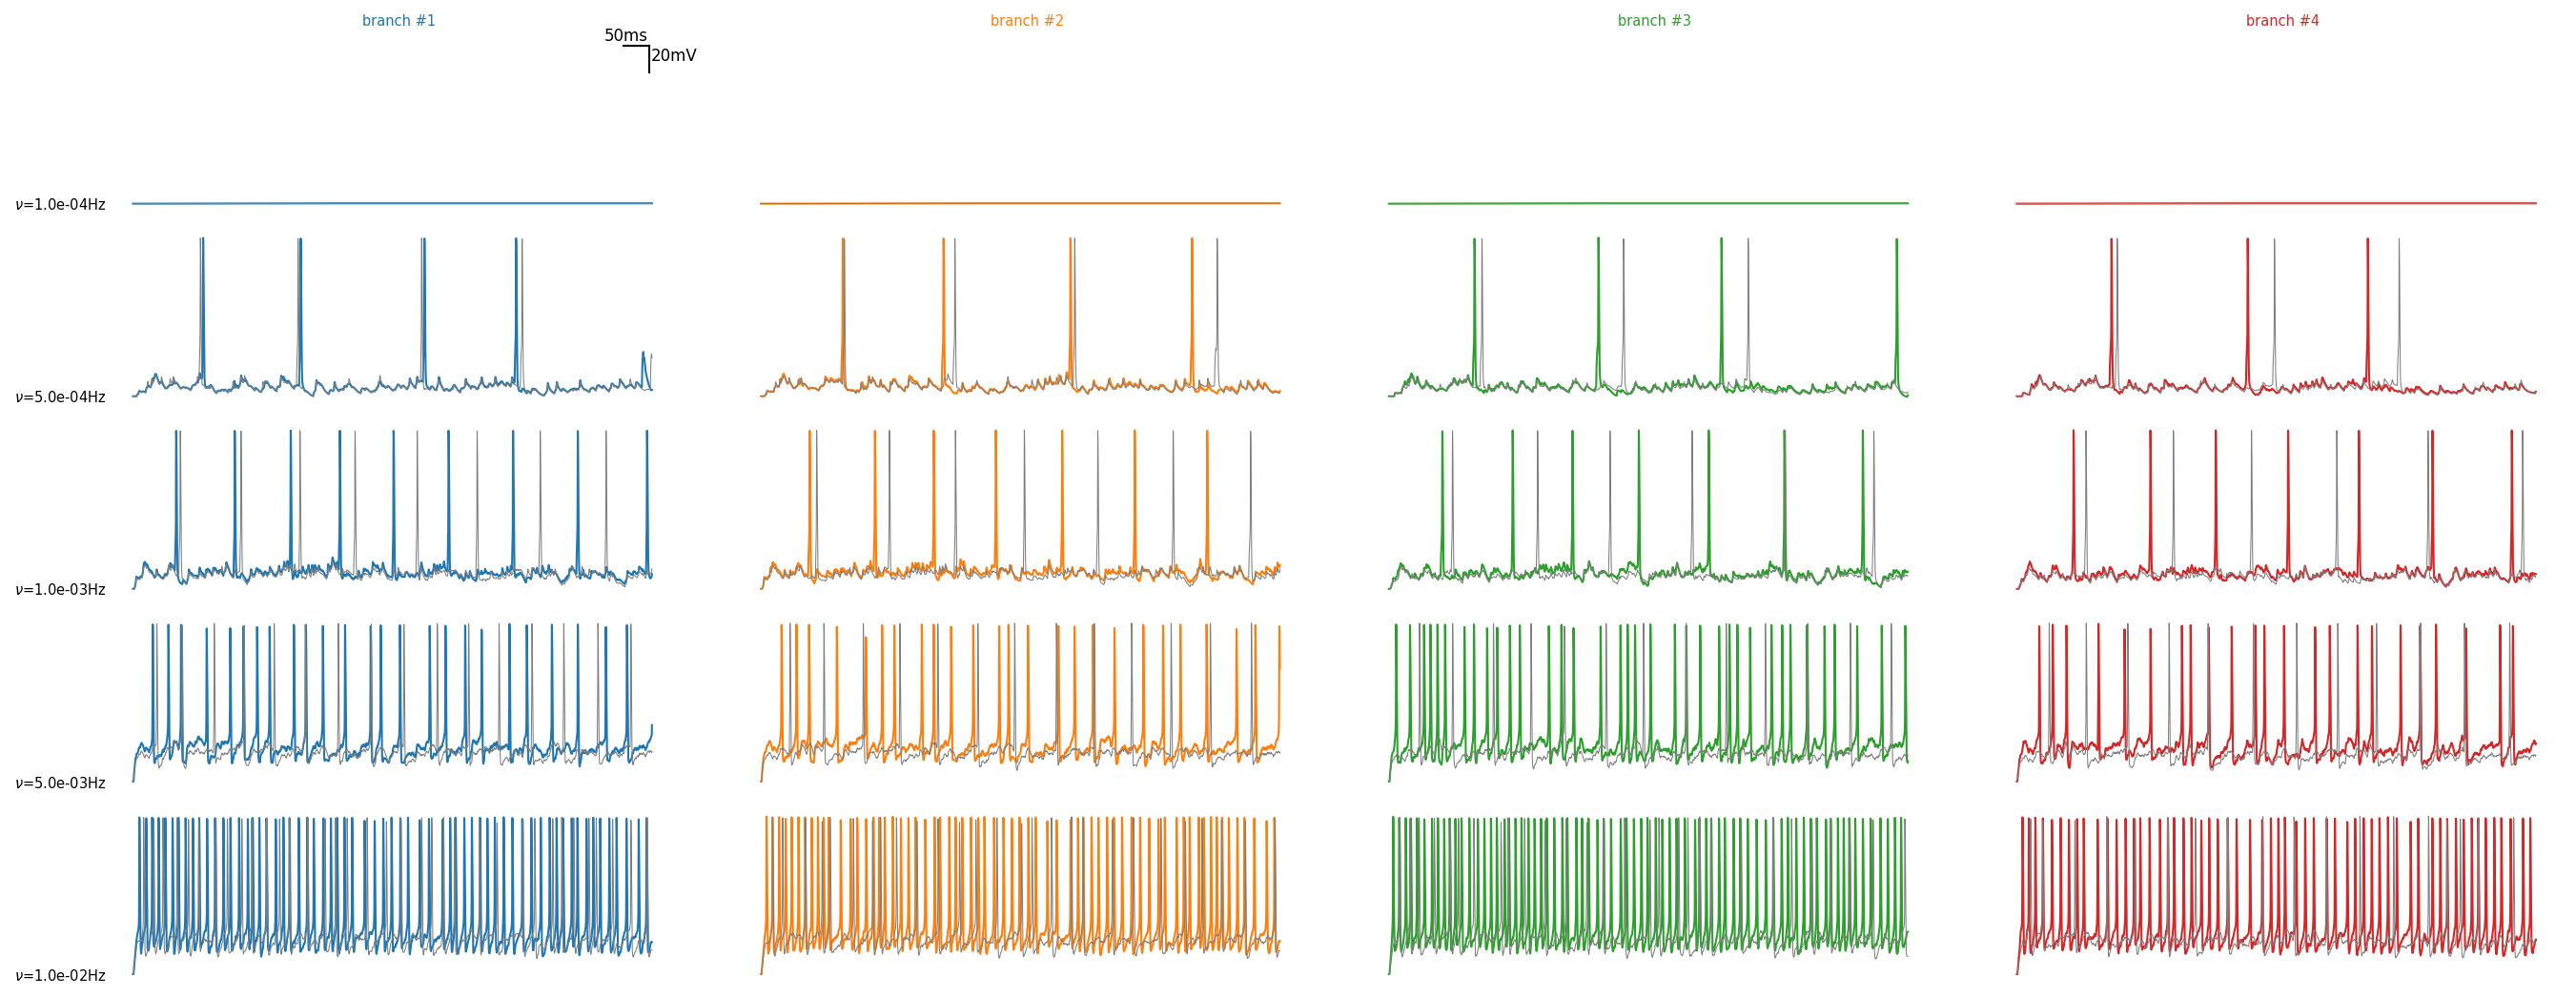

In [3]:
import numpy as np
import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

fig, AX = pt.figure(axes=(len(np.unique(sim.iBranch)), len(np.unique(sim.bgStimFreq))),
                    figsize=2*np.array((1.,0.7)), reshape_axes=False)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

trial = 2
dt = 0.025

for iB, iBranch in enumerate(np.unique(sim.iBranch)):
    c= plt.cm.tab10(iB)
    AX[0][iB].set_title('   branch #%i' % (1+iBranch), fontsize=7, color=c)
    for iF, bgStimFreq in enumerate(np.unique(sim.bgStimFreq)):
        if iB==0:
            pt.annotate(AX[iF][0], '$\\nu$=%.1eHz ' % bgStimFreq, (0, 0), ha='right', fontsize=7)
        for from_uniform, color, lw in zip([False, True], [c, 'tab:grey'], [1, 0.5]):
            Vm = sim.get('Vm', dict(from_uniform=from_uniform,
                                    iBranch=iBranch,
                                    bgStimFreq=bgStimFreq))[0]
            AX[iF][iB].plot(np.arange(len(Vm))*dt, Vm, color=color, lw=lw)
            AX[iF][iB].axis('off')
            
pt.set_common_ylims(AX)
pt.set_common_ylims(AX)
pt.draw_bar_scales(AX[0][0], loc='top-right',
                   Xbar=50, Xbar_label='50ms',
                   Ybar=20, Ybar_label='20mV')

#fig.savefig('/tmp/1.svg')

### Trace with dendritic $V_m$

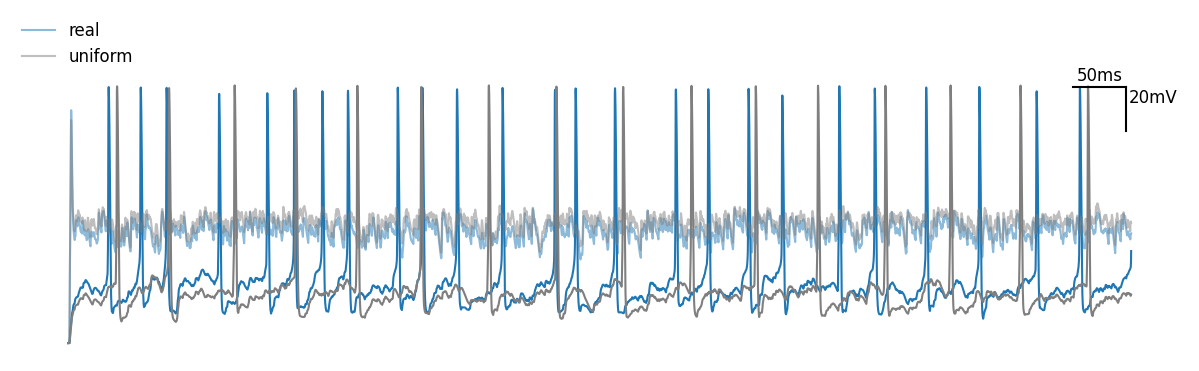

In [10]:
fig, ax = pt.figure(figsize=(3,3))

params = dict(iBranch = 0, bgStimFreq = 5e-3)

for from_uniform, color, label in zip([False, True], ['tab:blue', 'tab:grey'], ['real', 'uniform']):
    Vm = sim.get('Vm', dict(from_uniform=from_uniform, **params))[0]
    ax.plot(np.arange(len(Vm))*dt, Vm, color=color, lw=1)
    Vm = sim.get('Vm_dend', dict(from_uniform=from_uniform, **params))[0]
    ax.plot(np.arange(len(Vm))*dt, Vm, color=color, lw=1, label=label, alpha=0.5)
ax.legend(frameon=False, loc=(0,1))
ax.axis('off')

pt.draw_bar_scales(ax, loc='top-right',
                   Xbar=50, Xbar_label='50ms',
                   Ybar=20, Ybar_label='20mV')
#fig.savefig('/tmp/1.svg')

### Input-Output curves on all Branches

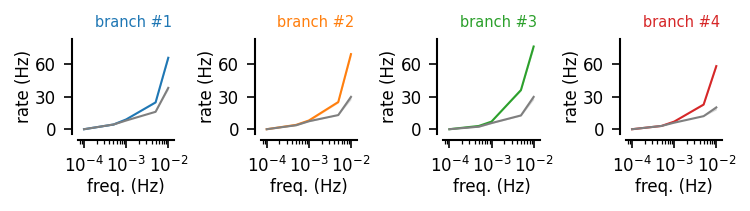

In [13]:
fig, AX = pt.figure(axes=(len(np.unique(sim.iBranch)), 1),
                    figsize=(0.9,1.0), reshape_axes=False)
plt.subplots_adjust(wspace=0.9)

for iB, iBranch in enumerate(np.unique(sim.iBranch)):
    c= plt.cm.tab10(iB)
    AX[0][iB].set_title('   branch #%i' % (1+iBranch), fontsize=7, color=c)
    for from_uniform, color, lw in zip([False, True], [c, 'tab:grey'], [1, 0.5]):
        params = {'iBranch':iBranch, 'from_uniform':from_uniform}
        mX = [sim.get('output_rate', dict(**params, bgStimFreq=f)).mean() for f in np.unique(sim.bgStimFreq)]
        sX = [sim.get('output_rate', dict(**params, bgStimFreq=f)).std() for f in np.unique(sim.bgStimFreq)]
        pt.plot(np.unique(sim.bgStimFreq), mX, sy=sX, ax=AX[0][iB], color=color, ms=1)
    pt.set_plot(AX[0][iB], xlabel='freq. (Hz)', ylabel='rate (Hz)', xscale='log')
    
pt.set_common_ylims(AX)
pt.set_common_ylims(AX)

## Summary Input-Output curve for the Basket Cell

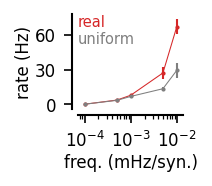

In [35]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../..')
import plot_tools as pt

from parallel import Parallel
sim = Parallel(\
        filename='../../data/detailed_model/Basket_bgStim_sim.zip')

sim.load()
sim.fetch_quantity_on_grid('output_rate', dtype=float) 

fig, ax = pt.figure(figsize=(0.9,1.0))

Fin, Fout = np.unique(sim.bgStimFreq), {'real':[], 'uniform':[]}
for k, key, color in zip([0,1], ['real', 'uniform'], ['tab:red', 'tab:grey']):
    for iB, iBranch in enumerate(np.unique(sim.iBranch)):
        params = {'iBranch':iBranch, 'from_uniform':(key=='uniform')}
        Fout[key].append(\
            [sim.get('output_rate', dict(**params, bgStimFreq=f)).mean() for f in np.unique(sim.bgStimFreq)])
    pt.scatter(Fin, np.mean(Fout[key], axis=0), sy=np.std(Fout[key], axis=0), 
               color=color, ms=1, lw=0.5, ax=ax)
    pt.annotate(ax, k*'\n'+key, (0,1), va='top', color=color, fontsize=7)
pt.set_plot(ax, xlabel='freq. (mHz/syn.)', ylabel='rate (Hz)', xscale='log')

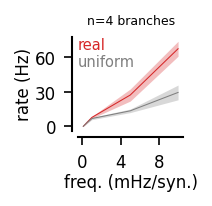

In [34]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../..')
import plot_tools as pt

from parallel import Parallel
sim = Parallel(\
        filename='../../data/detailed_model/Basket_bgStim_sim.zip')

sim.load()
sim.fetch_quantity_on_grid('output_rate', dtype=float) 

fig, ax = pt.figure(figsize=(0.9,1.0))

Fin, Fout = np.unique(sim.bgStimFreq), {'real':[], 'uniform':[]}
for k, key, color in zip([0,1], ['real', 'uniform'], ['tab:red', 'tab:grey']):
    for iB, iBranch in enumerate(np.unique(sim.iBranch)):
        params = {'iBranch':iBranch, 'from_uniform':(key=='uniform')}
        Fout[key].append(\
            [sim.get('output_rate', dict(**params, bgStimFreq=f)).mean() for f in np.unique(sim.bgStimFreq)])
    pt.plot(1e3*Fin, np.mean(Fout[key], axis=0), sy=np.std(Fout[key], axis=0), 
               color=color, ms=1, lw=0.5, ax=ax)
    pt.annotate(ax, k*'\n'+key, (0,1), va='top', color=color, fontsize=7)
ax.set_title('n=%i branches' % (iBranch+1), color='k', fontsize=6)
pt.set_plot(ax, xlabel='freq. (mHz/syn.)', ylabel='rate (Hz)')#, xscale='log')